# Strategie ewolucyjne

Notebook pokazuje podstawowe mechanizmy strategii ewolucyjnych.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

In [6]:
def gen_points(start_point, angles, lengths):
    n = len(angles)
    xs = np.zeros(n+1)
    ys = np.zeros(n+1)
    xs[0] = start_point[0]
    ys[0] = start_point[1]
    last_angle = 0
    for i in range(n):
        angle = last_angle - angles[i]
        xs[i+1] = xs[i] + lengths[i] * math.sin(math.radians(angle))
        ys[i+1] = ys[i] + lengths[i] * math.cos(math.radians(angle))
        last_angle = angle
    return xs, ys

In [7]:
def objective_function(angles, lengths, start_point, target, ranges=None, penalty=None):
    if penalty is None:
        penalty = np.sum(lengths) * 1000

    score = 0
    n = len(angles)
    if ranges is not None:
        for i in range(n):
            if angles[i] < ranges[i, 0] or angles[i] > ranges[i, 1]:
                score -= penalty
    xs, ys = gen_points(start_point, angles, lengths)
    score -= np.sqrt((target[0] - xs[-1])**2 + (target[1] - ys[-1])**2)
    return score

In [26]:
def plot_path(start_point, angles, lengths):
    xs, ys = gen_points(start_point, angles, lengths)
    plt.plot(xs, ys)
    

In [63]:
def cma_es(objective_function, chromosome_length, population_size, number_of_iterations, 
           number_of_offspring, ranges=None, log_frequency=1):
    
    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.0
    C = np.identity(chromosome_length)
    m = np.zeros(chromosome_length)
    sigma = np.ones(chromosome_length)
    p_sigma = 0.0
    p_C = 0.0
    
    mins = []
    maxs = []
    if ranges is not None:
        mins = ranges[:, 0].reshape(-1, 1)
        maxs = ranges[:, 1].reshape(-1, 1)
    
    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_sigmas = np.empty(number_of_iterations)
    
    current_population_solutions = m + sigma * np.dot(np.random.randn(population_size, chromosome_length), 
                                                  np.linalg.cholesky(C).T)
    
    if ranges is not None:
        current_population_solutions = np.clip(current_population_solutions.T, mins, maxs).T
    
    current_population_objective_values = np.zeros(population_size)
    for i in range(population_size):
        current_population_objective_values[i] = objective_function(current_population_solutions[i, :])
    
    
    for t in range(number_of_iterations):
        
#         Choosing children
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)
        children_population_solutions = current_population_solutions[parent_indices, :]
        
        
        children_population_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_population_objective_values[i] = objective_function(children_population_solutions[i, :])
        
        fitness_values = children_population_objective_values - children_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        
        # Cumulative Step-Size Adaptation(CSA)
        n = chromosome_length
#         weights = fitness_values
        weights = np.zeros(number_of_offspring) + 1/number_of_offspring
        c_sigma = 4/n
        d_sigma = 1
        y = np.sum(weights.reshape(-1, 1) * (children_population_solutions - m.reshape(1, -1)), axis=0)
        mi = (1.0 / weights ** 2).sum()
        m = m + sigma*y
        p_sigma = (1-c_sigma) * p_sigma + np.sqrt(1 - (1-c_sigma)**2) * np.sqrt(mi) * y
        sigma = sigma * np.exp(c_sigma / d_sigma * np.sqrt((p_sigma**2).sum()) / \
                (np.sqrt(n) * (1 - 1/(4*n)) + 1/(21 * n**2)))
        
        print(C)
#         Covariance Matrix Adaptation(CMA) –Rank-One Update
        current_population_solutions = m + sigma * np.dot(np.random.randn(population_size, chromosome_length), 
                                                  np.linalg.cholesky(C).T)
        
        if ranges is not None:
            current_population_solutions = np.clip(current_population_solutions.T, mins, maxs).T 
            
        current_population_objective_values = np.zeros(population_size)
        for i in range(population_size):
            current_population_objective_values[i] = objective_function(current_population_solutions[i, :])
        
        
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)
        children_population_solutions = current_population_solutions[parent_indices, :]
        
        
        children_population_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_population_objective_values[i] = objective_function(children_population_solutions[i, :])
        
        fitness_values = children_population_objective_values - children_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        
        n = chromosome_length
        c_cov = 2/n**2
#         weights = fitness_values
        weights = np.zeros(number_of_offspring) + 1/number_of_offspring
    
        y = np.sum(weights.reshape(-1, 1) * (children_population_solutions - m.reshape(1, -1)), axis=0)
        mi = (1.0 / weights ** 2).sum()
        m = m + sigma*y
        
        print((1-c_cov) * C, c_cov * mi * y.reshape(-1, 1) @ y.reshape(1, -1))
        C = (1-c_cov) * C + c_cov * mi * (y.reshape(-1, 1) @ y.reshape(1, -1))
        
#         print(C)
        current_population_solutions = m + sigma * np.dot(np.random.randn(population_size, chromosome_length), 
                                                  np.linalg.cholesky(C).T)
        
        if ranges is not None:
            current_population_solutions = np.clip(current_population_solutions.T, mins, maxs).T
        
        current_population_objective_values = np.zeros(population_size)
        for i in range(population_size):
            current_population_objective_values[i] = objective_function(current_population_solutions[i, :])
        
        
        
        idx_best = np.argmax(current_population_objective_values)
        if best_solution_objective_value < current_population_objective_values[idx_best]:
            best_solution = current_population_solutions[idx_best, :]
            best_solution_objective_value = current_population_objective_values[idx_best]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[idx_best, :]
        log_sigmas = np.empty(number_of_iterations)
        
        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))
    
    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

In [64]:
d = 20
N = 800
T = 2
start_point = np.array([0, 0])
target = np.array([10, 20])
ranges = np.array([[-180, 180]]*d)
lengths = np.array([1,3] * (d//2))

best_solution_objective_value, best_solution, history_objective_values, history_best_chromosome, history_best_sigmas = cma_es(
    lambda x: objective_function(x, lengths, start_point, target, ranges=ranges, penalty=None), 
    d, 2*N, T, N, ranges=None, log_frequency=1)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

LinAlgError: Matrix is not positive definite

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

In [ ]:
for i in range(0, 2, T):
    plot_path(start_point, history_best_chromosome[i, :], lengths)

In [52]:
test_d = 2
test_size = 10
test_m = np.array([100, 50])
test_C = np.array([[0.5, 0.25], [0.25, 0.25]])
test_sigma = 1
test_m + np.dot(np.random.randn(test_size, test_d), np.linalg.cholesky(test_C).T)
# np.random.multivariate_normal(test_m, test_sigma**2 * test_C,(test_size, test_d))

array([[ 99.37366862,  49.18605544],
       [100.52427365,  50.27564906],
       [100.38505335,  50.56326642],
       [100.19416207,  50.64149033],
       [ 99.58377902,  49.64804592],
       [100.42310017,  50.15269979],
       [ 99.51260377,  49.88873048],
       [100.88039082,  50.23149521],
       [100.86040416,  51.13383999],
       [ 99.88491417,  49.59278386]])

[ 0.0000000e+00  0.0000000e+00 -1.2246468e-16  2.0000000e+00
  2.0000000e+00 -2.0000000e+00 -2.0000000e+00  4.0000000e+00
  4.0000000e+00 -4.0000000e+00 -4.0000000e+00] [ 0.  0. -1. -1.  2.  2. -3. -3.  4.  4. -5.]


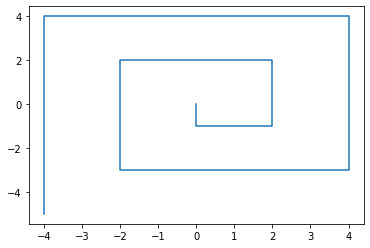

In [41]:
test_start_point = np.array([0,0])
test_angles = np.zeros(10) + 90
test_lengths = np.arange(10)
test_xs, test_ys = gen_points(test_start_point, test_angles, test_lengths)
print(test_xs, test_ys)
plt.plot(test_xs, test_ys)

In [ ]:
# wi = mi - i + 1